# Transfer Learning

In [1]:
!pip install tensorflow_io

In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

## Load data

We will use the test set of the "speech commands" dataset published by Peter Warden in conjunction with the paper [1804.03209](https://arxiv.org/abs/1804.03209).

The training set is located [here](http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz).

In [3]:
_ = tf.keras.utils.get_file('speech_commands.zip',
                        'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

In [4]:
data = []
labels_dict = {}
i = -1
for folder, labels, samples in os.walk('./datasets/'):
    if folder[11:]:
        i += 1
        labels_dict[i] = folder[11:]
    for sample in samples:
        if sample[-3:] == 'wav':
            data.append([folder+'/'+sample, i, folder[11:]])
labels_reverse_dict = {y:x for x,y in labels_dict.items()}

In [5]:
data = pd.DataFrame(data, columns=['filename', 'label', 'category'])
data.head()

,filename,label,category
0,./datasets/off/f2e59fea_nohash_2.wav,0,off
1,./datasets/off/f428ca69_nohash_0.wav,0,off
2,./datasets/off/422d3197_nohash_0.wav,0,off
3,./datasets/off/6736bc64_nohash_0.wav,0,off
4,./datasets/off/db24628d_nohash_0.wav,0,off


In [7]:
labels_reverse_dict.keys()

dict_keys(['off', 'stop', 'no', 'up', '_unknown_', 'right', '_silence_', 'go', 'left', 'yes', 'on', 'down'])

In [8]:
data['category'].unique()

array(['off', 'stop', 'no', 'up', '_unknown_', 'right', '_silence_', 'go',
       'left', 'yes', 'on', 'down'], dtype=object)

In [9]:
data_shuffled = data.sample(frac = 1)

In [10]:
nums = 4400
train_data_paths = np.array(data_shuffled['filename'][:nums])
train_labels = np.array(data_shuffled['label'][:nums])
test_data_paths = np.array(data_shuffled['filename'][nums:])
test_labels = np.array(data_shuffled['label'][nums:])

In [13]:
def load_audio(filepath):
    audio = tfio.audio.AudioIOTensor(filepath)
    audio_rate = int(audio.rate)
    assert audio_rate == 16000
    return tf.cast(tf.squeeze(audio.to_tensor(), axis=[-1]), tf.float32) / 32767.0

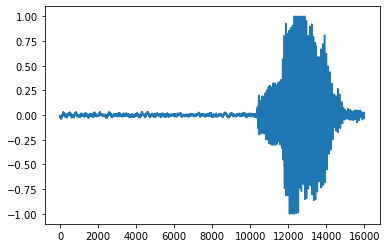

In [23]:
testing_file = train_data_paths[-1]
testing_sample = load_audio(testing_file)


_ = plt.plot(testing_sample)

# Play the audio file.
display.Audio(testing_sample,rate=16000)

## Train a model from scratch

In [25]:
nums = 4400
train_data_paths = np.array(data_shuffled['filename'][:nums])
train_labels = np.array(data_shuffled['label'][:nums])
test_data_paths = np.array(data_shuffled['filename'][nums:])
test_labels = np.array(data_shuffled['label'][nums:])

In [48]:
train_data = []
for path in train_data_paths:
    train_data.append(load_audio(path))

test_data = []
for path in test_data_paths:
    test_data.append(load_audio(path))

In [30]:
train_data[0]

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([ 6.1037019e-05,  6.1037019e-05,  6.1037019e-05, ...,
       -1.2207404e-04, -9.1555528e-05, -9.1555528e-05], dtype=float32)>

In [31]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [32]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

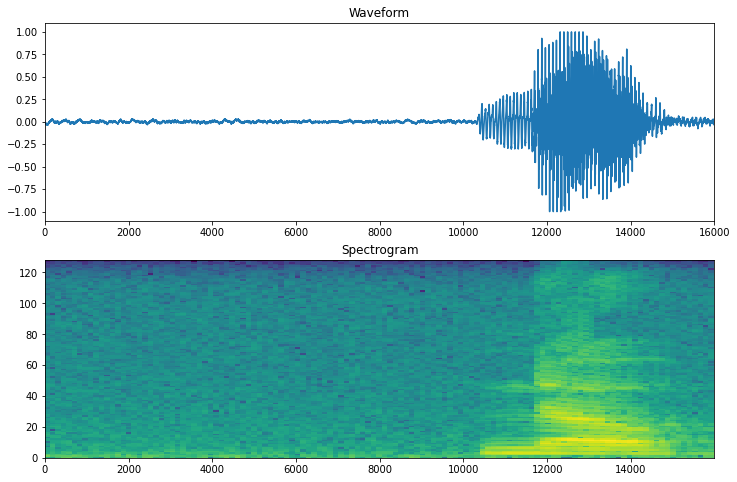

In [33]:
waveform = testing_sample
spectrogram = get_spectrogram(waveform)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()
display.Audio(testing_sample,rate=16000)

In [37]:
train_data_s = []
for i in range(len(train_data)):
    train_data_s.append(get_spectrogram(train_data[i]))

train_data_s = np.array(train_data_s)
train_data_s.shape

(4400, 124, 129, 1)

In [38]:
train_labels.shape

(4400,)

In [45]:
input_shape = spectrogram.shape
num_labels = len(labels_dict)
model = keras.Sequential([layers.Input(shape=input_shape),
                          layers.Resizing(32, 32),
                          layers.Conv2D(32, 3, activation='relu'),
                          layers.Conv2D(64, 3, activation='relu'),
                          layers.MaxPooling2D(),
                          layers.Dropout(0.25),
                          layers.Flatten(),
                          layers.Dense(128, activation='relu'),
                          layers.Dropout(0.5),
                          layers.Dense(num_labels, activation='softmax'),
                          ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                      

In [46]:
#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

In [47]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3, restore_best_weights=True)

model.fit(train_data_s, train_labels, epochs=60, batch_size=256,
          validation_split=0.2, shuffle=True, callbacks = callback)

Epoch 1/60
14/14 [==============================] - 15s 1s/step - loss: 2.2832 - accuracy: 0.2412 - val_loss: 2.0391 - val_accuracy: 0.3659
Epoch 2/60
14/14 [==============================] - 12s 836ms/step - loss: 1.9357 - accuracy: 0.3716 - val_loss: 1.8200 - val_accuracy: 0.4602
Epoch 3/60
14/14 [==============================] - 12s 833ms/step - loss: 1.7672 - accuracy: 0.4261 - val_loss: 1.6381 - val_accuracy: 0.5352
Epoch 4/60
14/14 [==============================] - 12s 837ms/step - loss: 1.5750 - accuracy: 0.4943 - val_loss: 1.5352 - val_accuracy: 0.5511
Epoch 5/60
14/14 [==============================] - 12s 835ms/step - loss: 1.4176 - accuracy: 0.5344 - val_loss: 1.4323 - val_accuracy: 0.5682
Epoch 6/60
14/14 [==============================] - 12s 836ms/step - loss: 1.2813 - accuracy: 0.5838 - val_loss: 1.3144 - val_accuracy: 0.6114
Epoch 7/60
14/14 [==============================] - 12s 843ms/step - loss: 1.1580 - accuracy: 0.6196 - val_loss: 1.2256 - val_accuracy: 0.6364
Ep

In [50]:
test_data_s = []
for i in range(len(test_data)):
    test_data_s.append(get_spectrogram(test_data[i]))

test_data_s = np.array(test_data_s)
test_data_s.shape

(490, 124, 129, 1)

In [51]:
model.evaluate(test_data_s, test_labels)

16/16 [==============================] - 1s 41ms/step - loss: 1.0678 - accuracy: 0.7204


[1.067779302597046, 0.7204081416130066]

A model from scratch on ~4000 samples can achieve 70-75% accuracy which is not bad. Now let's see what we can do with a pretrained model.

## Load pretrained model

We will use the YAMNet audio recognition model. YAMNet has not been trained as a speech recognition model, rather it was trained to classify sounds into classes such as 'shatter', 'laughter' and 'child speech'.

As a model that has also listened to human speech during training, YAMNet has learned to extract features that should be quite suitable for speech recognition.

In [53]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

### Test the model

The model has 3 outputs the one of which is a classification with the following classes:

In [57]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

class_names[:20]

['Speech',
 'Child speech, kid speaking',
 'Conversation',
 'Narration, monologue',
 'Babbling',
 'Speech synthesizer',
 'Shout',
 'Bellow',
 'Whoop',
 'Yell',
 'Children shouting',
 'Screaming',
 'Whispering',
 'Laughter',
 'Baby laughter',
 'Giggle',
 'Snicker',
 'Belly laugh',
 'Chuckle, chortle',
 'Crying, sobbing']

We can test this on our recorings of commands which should obviously be classified as speech!

## Transfer learning (indirect approach)

YAMNet is a pretty heavy model. We will look at it in detail later but since the model outputs "extracted features" for us to use, we can directly use those features and train a new model to classify our new data.

In [96]:
train_data_te = []
train_data_ts = []
for i in range(len(train_data)):
    x = yamnet_model(train_data[i])[1:]
    train_data_te.append(x[0])
    train_data_ts.append(x[1])

In [98]:
train_data_te = tf.convert_to_tensor(train_data_te)
train_data_ts = tf.convert_to_tensor(train_data_ts)

[train_data_te.shape, train_data_ts.shape]

[TensorShape([4400, 2, 1024]), TensorShape([4400, 144, 64])]

### Using encodings

The model extracts "frames" of 0.96s duration every 0.48s. For our 1s long data this is simply a shift in the waveform which nonetheless can be treated as a new sample.

In [102]:
train_data_te = tf.reshape(train_data_te, (-1, 1024))
train_labels_te = np.repeat(train_labels,2)

In [99]:
num_classes = len(labels_dict)

model_te = keras.Sequential([layers.Input(shape=(1024)),
                             layers.Dense(256, activation='relu'),
                             layers.Dense(num_classes, activation='softmax')
                             ])

model_te.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               262400    
                                                                 
 dense_7 (Dense)             (None, 12)                3084      
                                                                 
Total params: 265,484
Trainable params: 265,484
Non-trainable params: 0
_________________________________________________________________


In [103]:
model_te.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam", metrics=['accuracy'])

In [104]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3, restore_best_weights=True)

model_te.fit(train_data_te, train_labels_te, epochs=60, batch_size=256,
             validation_split=0.2, shuffle=True, callbacks = callback)

Epoch 1/60
28/28 [==============================] - 1s 27ms/step - loss: 2.2603 - accuracy: 0.2295 - val_loss: 2.1471 - val_accuracy: 0.2506
Epoch 2/60
28/28 [==============================] - 1s 19ms/step - loss: 2.0243 - accuracy: 0.3136 - val_loss: 2.0298 - val_accuracy: 0.2937
Epoch 3/60
28/28 [==============================] - 1s 18ms/step - loss: 1.9319 - accuracy: 0.3480 - val_loss: 1.9760 - val_accuracy: 0.3267
Epoch 4/60
28/28 [==============================] - 1s 18ms/step - loss: 1.8517 - accuracy: 0.3710 - val_loss: 1.9504 - val_accuracy: 0.3307
Epoch 5/60
28/28 [==============================] - 1s 18ms/step - loss: 1.7960 - accuracy: 0.3862 - val_loss: 1.9182 - val_accuracy: 0.3506
Epoch 6/60
28/28 [==============================] - 0s 17ms/step - loss: 1.7517 - accuracy: 0.4026 - val_loss: 1.8955 - val_accuracy: 0.3602
Epoch 7/60
28/28 [==============================] - 1s 19ms/step - loss: 1.7049 - accuracy: 0.4222 - val_loss: 1.8583 - val_accuracy: 0.3574
Epoch 8/60
28

In [110]:
test_data_te=[]
test_data_ts=[]
for i in range(len(test_data)):
    x = yamnet_model(test_data[i])[1:]
    test_data_te.append( x[0] )
    test_data_ts.append( x[1] )

test_data_te = tf.reshape( test_data_te,(-1, 1024) )
test_labels_te = np.repeat(test_labels,2)

In [108]:
model_te.evaluate(test_data_te, test_labels_te)

31/31 [==============================] - 0s 3ms/step - loss: 1.8568 - accuracy: 0.3592


[1.856785774230957, 0.359183669090271]

Clearly you can do a lot better by training a model from scratch! That's generally true if you have enough data and ~5000 samples for 12 classes is enough to train a model reasonably well. 

### Using spectrograms

In [114]:
train_data_ts = tf.reshape(train_data_ts, (4400, 144, 64, 1))

In [126]:
num_labels = len(labels_dict)
model_ts = keras.Sequential([layers.Input(shape=(144, 64, 1)),
                             layers.Resizing(32, 32),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Dropout(0.25),
                             layers.Flatten(),
                             layers.Dense(128, activation='relu'),
                             layers.Dropout(0.5),
                             layers.Dense(num_labels, activation='softmax'),
                             ])

model_ts.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 6272)              0         
                                                      

In [128]:
model_ts.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam", metrics=['accuracy'])

In [129]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3, restore_best_weights=True)

model_ts.fit(train_data_ts, train_labels, epochs=60, batch_size=256,
             validation_split=0.2, callbacks = callback)

Epoch 1/60
14/14 [==============================] - 13s 837ms/step - loss: 2.5456 - accuracy: 0.1361 - val_loss: 2.3548 - val_accuracy: 0.2102
Epoch 2/60
14/14 [==============================] - 9s 610ms/step - loss: 2.2550 - accuracy: 0.2273 - val_loss: 2.1143 - val_accuracy: 0.3136
Epoch 3/60
14/14 [==============================] - 8s 538ms/step - loss: 2.0498 - accuracy: 0.3080 - val_loss: 1.8600 - val_accuracy: 0.4398
Epoch 4/60
14/14 [==============================] - 8s 539ms/step - loss: 1.8210 - accuracy: 0.3935 - val_loss: 1.5988 - val_accuracy: 0.5068
Epoch 5/60
14/14 [==============================] - 8s 539ms/step - loss: 1.6168 - accuracy: 0.4622 - val_loss: 1.4047 - val_accuracy: 0.5568
Epoch 6/60
14/14 [==============================] - 8s 540ms/step - loss: 1.4738 - accuracy: 0.5068 - val_loss: 1.3175 - val_accuracy: 0.5784
Epoch 7/60
14/14 [==============================] - 8s 540ms/step - loss: 1.3577 - accuracy: 0.5452 - val_loss: 1.1765 - val_accuracy: 0.6318
Epoch

In [132]:
test_data_ts = tf.convert_to_tensor(test_data_ts)

In [133]:
model_ts.evaluate(test_data_ts, test_labels)

16/16 [==============================] - 1s 36ms/step - loss: 0.7403 - accuracy: 0.7531


[0.7403245568275452, 0.7530612349510193]

## What if you have fewer samples?

In [134]:
nums_train = 400
nums_test = 40

### End to end

In [142]:
input_shape = spectrogram.shape
num_labels = len(labels_dict)
model_2 = keras.Sequential([layers.Input(shape=input_shape),
                            layers.Resizing(32, 32),
                            layers.Conv2D(32, 3, activation='relu'),
                            layers.Conv2D(64, 3, activation='relu'),
                            layers.MaxPooling2D(),
                            layers.Dropout(0.25),
                            layers.Flatten(),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.5),
                            layers.Dense(num_labels),
                            ])

model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_9 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 flatten_9 (Flatten)         (None, 12544)             0         
                                                     

In [143]:
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer="adam", metrics=['accuracy'])

In [144]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=5, restore_best_weights=True)

model_2.fit(train_data_s[:nums_train], train_labels[:nums_train], epochs=60, batch_size=256,
            validation_split=0.1, callbacks = callback)

Epoch 1/60
2/2 [==============================] - 3s 980ms/step - loss: 2.5076 - accuracy: 0.0806 - val_loss: 2.4024 - val_accuracy: 0.1250
Epoch 2/60
2/2 [==============================] - 2s 549ms/step - loss: 2.2939 - accuracy: 0.2167 - val_loss: 2.3818 - val_accuracy: 0.2000
Epoch 3/60
2/2 [==============================] - 2s 491ms/step - loss: 2.1520 - accuracy: 0.3000 - val_loss: 2.3920 - val_accuracy: 0.2000
Epoch 4/60
2/2 [==============================] - 2s 607ms/step - loss: 2.0468 - accuracy: 0.3139 - val_loss: 2.4005 - val_accuracy: 0.2750
Epoch 5/60
2/2 [==============================] - 2s 624ms/step - loss: 1.9753 - accuracy: 0.3639 - val_loss: 2.3803 - val_accuracy: 0.3250
Epoch 6/60
2/2 [==============================] - 2s 617ms/step - loss: 1.8620 - accuracy: 0.4194 - val_loss: 2.3067 - val_accuracy: 0.2250
Epoch 7/60
2/2 [==============================] - 2s 606ms/step - loss: 1.7866 - accuracy: 0.4278 - val_loss: 2.2221 - val_accuracy: 0.2750
Epoch 8/60
2/2 [====

In [145]:
model_2.evaluate(test_data_s[:nums_test], test_labels[:nums_test])

2/2 [==============================] - 0s 20ms/step - loss: 2.1822 - accuracy: 0.2500


[2.1822266578674316, 0.25]

### Transfer learning

In [ ]:
num_classes = len(labels_dict)

model_te_2 = keras.Sequential([layers.Input(shape=(1024)),
                               layers.Dense(256, activation='relu', 
                                            kernel_regularizer='l1_l2'),
                               layers.Dropout(0.5),
                               layers.Dense(num_classes, activation='softmax')
                               ])

model_te_2.summary()

In [193]:
model_te_2.compile(loss="sparse_categorical_crossentropy",
                   optimizer="adam", metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=5, restore_best_weights=True)

model_te_2.fit(train_data_te[:2*nums_train], train_labels[:2*nums_train],
               epochs=60, batch_size=256, validation_split=0.1, 
               shuffle=True, callbacks = callback)

In [ ]:
num_labels = len(labels_dict)
model_ts_2 = keras.Sequential([layers.Input(shape=(144, 64, 1)),
                               layers.Resizing(32, 32),
                               layers.Conv2D(32, 3, activation='relu'),
                               layers.Conv2D(32, 3, activation='relu'),
                               layers.MaxPooling2D(),
                               layers.Dropout(0.25),
                               layers.Flatten(),
                               layers.Dense(128, activation='relu'),
                               layers.Dropout(0.5),
                               layers.Dense(num_labels, activation='softmax'),
                               ])

model_ts_2.summary()

In [209]:
model_ts_2.compile(loss="sparse_categorical_crossentropy",
                   optimizer="adam", metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=5, restore_best_weights=True)

model_ts_2.fit(train_data_ts[:nums_train], train_labels[:nums_train], epochs=60, 
               batch_size=256, validation_split=0.1, callbacks = callback)

In [ ]:
model_ts_2.evaluate(test_data_ts[:nums_test], test_labels[:nums_test])

## Transfer Learning (direct approach)

Clearly YAMNet was not trained to recognize speech and some of the information is lost as data is passed through the model.

We can potentially prevent this loss of information but replacing the later layers of the model.

In [215]:
# Install required packages.
!pip install soundfile
!git clone https://github.com/tensorflow/models.git
%cd models/research/audioset/yamnet

# Download YAMNet data
!curl -O https://storage.googleapis.com/audioset/yamnet.h5

fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research/audioset/yamnet
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.5M  100 14.5M    0     0  40.7M      0 --:--:-- --:--:-- --:--:-- 40.6M


In [216]:
import soundfile as sf
import params as yamnet_params
import yamnet as yamnet_model

In [217]:
# Download audio for testing
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

# Read in the audio.
wav_file_name = 'speech_whistling2.wav'
wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
waveform = wav_data / 32768.0

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  153k  100  153k    0     0   809k      0 --:--:-- --:--:-- --:--:--  805k


In [218]:
# The graph is designed for a sampling rate of 16 kHz, but higher rates should work too.
# We also generate scores at a 10 Hz frame rate.
params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=0.1)
print("Sample rate =", params.sample_rate)

Sample rate = 16000


In [219]:
# Set up the YAMNet model.
class_names = yamnet_model.class_names('yamnet_class_map.csv')
yamnet = yamnet_model.yamnet_frames_model(params)
yamnet.load_weights('yamnet.h5')

In [220]:
# Run the model.
scores, embeddings, spectrogram = yamnet(waveform)
scores = scores.numpy()
spectrogram = spectrogram.numpy()

In [222]:
spectrogram

array([[-5.966911  , -5.9821906 , -6.012962  , ..., -5.2227764 ,
        -5.3245063 , -6.2055817 ],
       [-2.0070174 , -1.9400738 , -1.8753514 , ..., -2.9347801 ,
        -2.5981402 , -4.248978  ],
       [-0.9086907 , -1.2683843 , -0.42821464, ..., -3.363868  ,
        -3.4155478 , -4.4742885 ],
       ...,
       [-6.9077554 , -6.9077554 , -6.9077554 , ..., -6.9077554 ,
        -6.9077554 , -6.9077554 ],
       [-6.9077554 , -6.9077554 , -6.9077554 , ..., -6.9077554 ,
        -6.9077554 , -6.9077554 ],
       [-6.9077554 , -6.9077554 , -6.9077554 , ..., -6.9077554 ,
        -6.9077554 , -6.9077554 ]], dtype=float32)

In [309]:
yamnet.summary()

Model: "yamnet_frames"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (1,)                0           ['input_31[0][0]']               
 )                                                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  ()                  0           ['tf.compat.v1.shape[0][0]']     
 ingOpLambda)                                                                                     
                                                                                      

In [224]:
yamnet.outputs

[<KerasTensor: shape=(None, 521) dtype=float32 (created by layer 'activation')>,
 <KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'global_average_pooling2d')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'tf.math.log')>]

In [239]:
yamnet.inputs

[<KerasTensor: shape=(None,) dtype=float32 (created by layer 'input_31')>]

In [227]:
len(yamnet.layers)

106

In [328]:
yamnet.layers[27], yamnet.layers[27].output_shape

(<keras.layers.advanced_activations.ReLU at 0x7fb0ee3a1b90>,
 (None, 48, 32, 32))

In [361]:
yamnet.layers[57], yamnet.layers[57].output_shape

(<keras.layers.advanced_activations.ReLU at 0x7fb0dfd74b90>, (None, 6, 4, 256))

### Keeping only 27 layers

In [329]:
yamnet_truncated = keras.Model(inputs = yamnet.inputs,
                               outputs = yamnet.layers[27].output)

In [330]:
train_data_yamnet = []
for i in range(len(train_data)):
    train_data_yamnet.append(yamnet_truncated(train_data[i]))

In [331]:
train_data_yamnet = tf.convert_to_tensor(train_data_yamnet)
train_data_yamnet.shape

TensorShape([4400, 2, 48, 32, 32])

In [345]:
train_data_yamnet = tf.reshape(train_data_yamnet,(8800,48,32,32))

In [351]:
# YAMNet Speach Recognition
layer_input = keras.Input(shape=(48,32,32))
# same shape as yamnet.layers[27].output
layer_conv = layers.Conv2D(48,32)(layer_input)
layer_pool = layers.GlobalAveragePooling2D()(layer_conv)
layer_soft = layers.Dense(12, activation="softmax")(layer_pool)
yamnet_st = keras.Model(inputs = layer_input,
                        outputs = layer_soft)

In [352]:
yamnet_st.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 48, 32, 32)]      0         
                                                                 
 conv2d_45 (Conv2D)          (None, 17, 1, 48)         1572912   
                                                                 
 global_average_pooling2d_18  (None, 48)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_66 (Dense)            (None, 12)                588       
                                                                 
Total params: 1,573,500
Trainable params: 1,573,500
Non-trainable params: 0
_________________________________________________________________


In [353]:
yamnet_st.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam", metrics=['accuracy'])

In [354]:
train_data_yamnet.shape, train_labels_te.shape

(TensorShape([8800, 48, 32, 32]), (8800,))

In [355]:
yamnet_st.fit(train_data_yamnet, train_labels_te, epochs=100,
              batch_size=256, validation_split=0.2,
              callbacks=callback)

Epoch 1/100
28/28 [==============================] - 31s 1s/step - loss: 21.7093 - accuracy: 0.1875 - val_loss: 7.9657 - val_accuracy: 0.2034
Epoch 2/100
28/28 [==============================] - 31s 1s/step - loss: 3.2164 - accuracy: 0.4550 - val_loss: 1.9114 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 31s 1s/step - loss: 1.2081 - accuracy: 0.6426 - val_loss: 1.3074 - val_accuracy: 0.6159
Epoch 4/100
28/28 [==============================] - 31s 1s/step - loss: 0.9343 - accuracy: 0.7040 - val_loss: 1.2190 - val_accuracy: 0.6170
Epoch 5/100
28/28 [==============================] - 31s 1s/step - loss: 0.7894 - accuracy: 0.7455 - val_loss: 1.3342 - val_accuracy: 0.5773
Epoch 6/100
28/28 [==============================] - 31s 1s/step - loss: 0.7060 - accuracy: 0.7827 - val_loss: 1.1103 - val_accuracy: 0.6642
Epoch 7/100
28/28 [==============================] - 31s 1s/step - loss: 0.8552 - accuracy: 0.7308 - val_loss: 1.4312 - val_accuracy: 0.5699
Epoch 8/100


### 57 layers

In [362]:
yamnet_truncated = keras.Model(inputs = yamnet.inputs,
                               outputs = yamnet.layers[57].output)

In [363]:
train_data_yamnet = []
for i in range(len(train_data)):
    train_data_yamnet.append(yamnet_truncated(train_data[i]))

In [364]:
train_data_yamnet = tf.convert_to_tensor(train_data_yamnet)
train_data_yamnet.shape

TensorShape([4400, 2, 6, 4, 256])

In [371]:
train_data_yamnet = tf.reshape(train_data_yamnet,(8800,6,4,256))

In [376]:
# YAMNet Speach Recognition
layer_input = keras.Input(shape=(6,4,256))
# same shape as yamnet.layers[57].output
layer_conv = layers.Conv2D(6,4,256)(layer_input)
layer_pool = layers.GlobalAveragePooling2D()(layer_conv)
layer_soft = layers.Dense(12, activation="softmax")(layer_pool)
yamnet_st = keras.Model(inputs = layer_input,
                        outputs = layer_soft)

In [377]:
yamnet_st.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 6, 4, 256)]       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 1, 1, 6)           24582     
                                                                 
 global_average_pooling2d_22  (None, 6)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_70 (Dense)            (None, 12)                84        
                                                                 
Total params: 24,666
Trainable params: 24,666
Non-trainable params: 0
_________________________________________________________________


In [379]:
yamnet_st.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam", metrics=['accuracy'])

In [380]:
train_data_yamnet.shape, train_labels_te.shape

(TensorShape([8800, 6, 4, 256]), (8800,))

In [381]:
yamnet_st.fit(train_data_yamnet, train_labels_te, epochs=100,
              batch_size=256, validation_split=0.2,
              callbacks=callback)

Epoch 1/100
28/28 [==============================] - 1s 19ms/step - loss: 2.1869 - accuracy: 0.2713 - val_loss: 1.8563 - val_accuracy: 0.3818
Epoch 2/100
28/28 [==============================] - 0s 14ms/step - loss: 1.5588 - accuracy: 0.5013 - val_loss: 1.5380 - val_accuracy: 0.5045
Epoch 3/100
28/28 [==============================] - 0s 13ms/step - loss: 1.2741 - accuracy: 0.6014 - val_loss: 1.3545 - val_accuracy: 0.5574
Epoch 4/100
28/28 [==============================] - 0s 13ms/step - loss: 1.0849 - accuracy: 0.6653 - val_loss: 1.1939 - val_accuracy: 0.6460
Epoch 5/100
28/28 [==============================] - 0s 13ms/step - loss: 0.9270 - accuracy: 0.7352 - val_loss: 1.1026 - val_accuracy: 0.6534
Epoch 6/100
28/28 [==============================] - 0s 14ms/step - loss: 0.8077 - accuracy: 0.7757 - val_loss: 1.0031 - val_accuracy: 0.6983
Epoch 7/100
28/28 [==============================] - 0s 15ms/step - loss: 0.7134 - accuracy: 0.8098 - val_loss: 0.9491 - val_accuracy: 0.7102
Epoch 

In [382]:
test_data_yamnet = []
for i in range(len(test_data)):
    test_data_yamnet.append(yamnet_truncated(test_data[i]))

In [386]:
test_data_yamnet = tf.convert_to_tensor(test_data_yamnet)
test_data_yamnet = tf.reshape(test_data_yamnet,(-1,6,4,256))

In [387]:
test_data_yamnet.shape

TensorShape([980, 6, 4, 256])

In [388]:
yamnet_st.evaluate(test_data_yamnet, test_labels_te)

31/31 [==============================] - 0s 2ms/step - loss: 0.7998 - accuracy: 0.7592


[0.7998358011245728, 0.7591836452484131]